<a href="https://colab.research.google.com/github/Tirta2241720045/PCVK_Ganjil_2024/blob/main/Kuis%202%20PCVK/Percobaan_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

TRAIN_DIR = '/content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Training'
TEST_DIR = '/content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Testing'
OUTPUT_DIR = '/content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/'

def load_dataset(directory, target_size=(128, 128)):
    X = []
    Z = []
    classes = ['Ayam', 'Kambing', 'Sapi']

    for label in classes:
        folder_path = os.path.join(directory, label)
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Directory not found: {folder_path}")

        files = os.listdir(folder_path)
        print(f"Loading {len(files)} images for class {label} from {directory}")

        for img_name in files:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                X.append(img)
                Z.append(label)
            else:
                print(f"Warning: Could not load image {img_path}")

    return np.array(X), np.array(Z)

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(96, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def plot_training_history(history, output_dir):
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    # Save the plot to a file
    history_file_path = os.path.join(output_dir, "history_percobaan_C.png")
    plt.savefig(history_file_path)
    print(f"Training history plot saved to {history_file_path}")
    plt.close()  # Close the plot to free memory

def save_class_names(class_names, output_dir):
    file_path = os.path.join(output_dir, "class_names.txt")
    with open(file_path, "w") as file:
        for class_name in class_names:
            file.write(class_name + "\n")
    print(f"Class names saved to {file_path}")

def save_model(model, output_dir):
    model_path = os.path.join(output_dir, "daging_cnn_model.h5")
    model.save(model_path)
    print(f"Model saved to {model_path}")

def main():
    print("Loading training data...")
    X_train, Z_train = load_dataset(TRAIN_DIR)
    print("Loading testing data...")
    X_test, Z_test = load_dataset(TEST_DIR)

    le = LabelEncoder()
    y_train = le.fit_transform(Z_train)
    y_test = le.transform(Z_test)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen.fit(X_train)

    class_names = ['Ayam', 'Kambing', 'Sapi']
    save_class_names(class_names, OUTPUT_DIR)

    model = create_model((128, 128, 3), len(class_names))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    batch_size = 16

    train_generator = datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        shuffle=True
    )

    print("\nTraining model...")
    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    plot_training_history(history, OUTPUT_DIR)

    print("\nFinal evaluation on test set:")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test accuracy: {test_accuracy:.4f}')
    print(f'Test loss: {test_loss:.4f}')

    save_model(model, OUTPUT_DIR)

    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    print("\nPer-class accuracy:")
    for i in range(len(class_names)):
        mask = (true_classes == i)
        class_accuracy = np.mean(predicted_classes[mask] == true_classes[mask]) if np.any(mask) else 0
        print(f"{class_names[i]}: {class_accuracy:.4f}")

if __name__ == "__main__":
    main()


Loading training data...
Loading 80 images for class Ayam from /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Training
Loading 80 images for class Kambing from /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Training
Loading 80 images for class Sapi from /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Training
Loading testing data...
Loading 20 images for class Ayam from /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Testing
Loading 20 images for class Kambing from /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Testing
Loading 20 images for class Sapi from /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/Testing
Training samples: 240
Testing samples: 60
Class names saved to /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/class_names.txt


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,591,459 (25.14 MB)

 Trainable params: 6,591,459 (25.14 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3532 - loss: 1.4160 - val_accuracy: 0.3667 - val_loss: 1.0462 - learning_rate: 0.0010
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4811 - loss: 0.9669 - val_accuracy: 0.9000 - val_loss: 0.4771 - learning_rate: 0.0010
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6486 - loss: 0.7469 - val_accuracy: 0.8000 - val_loss: 0.4228 - learning_rate: 0.0010
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7592 - loss: 0.5966 - val_accuracy: 0.9167 - val_loss: 0.3909 - learning_rate: 0.0010
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7252 - loss: 0.6698 - val_accuracy: 0.9167 - val_loss: 0.2768 - learning_rate: 0.0010
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8304 - loss: 0.4486 - val_accuracy: 0.8833 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8019 - loss: 0.5243 - val_accuracy: 0.8833 - va

Test accuracy: 0.9167
Test loss: 0.1901
Model saved to /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/daging_cnn_model.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step

Per-class accuracy:
Ayam: 1.0000
Kambing: 0.9000
Sapi: 0.8500


Saving Kambing (9).jpg to Kambing (9) (3).jpg
Saving Sapi (9).JPG to Sapi (9) (3).JPG
Saving object6.jpg to object6 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


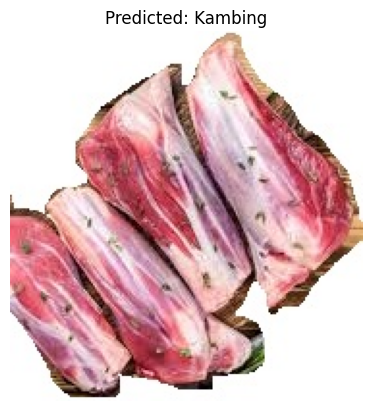

The predicted class for the image is: Kambing
Class probabilities:
Ayam: 0.00%
Kambing: 99.98%
Sapi: 0.02%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


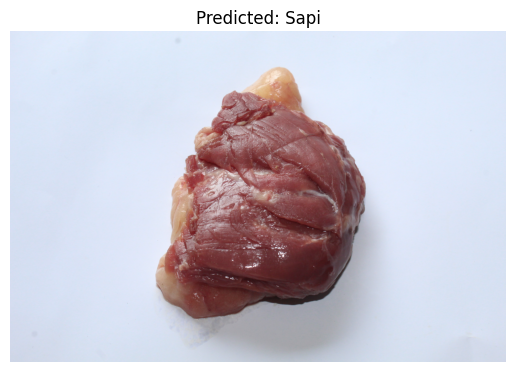

The predicted class for the image is: Sapi
Class probabilities:
Ayam: 0.01%
Kambing: 0.36%
Sapi: 99.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


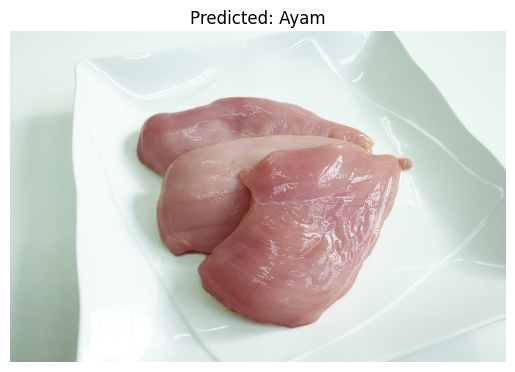

The predicted class for the image is: Ayam
Class probabilities:
Ayam: 92.20%
Kambing: 0.15%
Sapi: 7.65%
Prediction results plot saved as /content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/prediction_percobaan_C.png


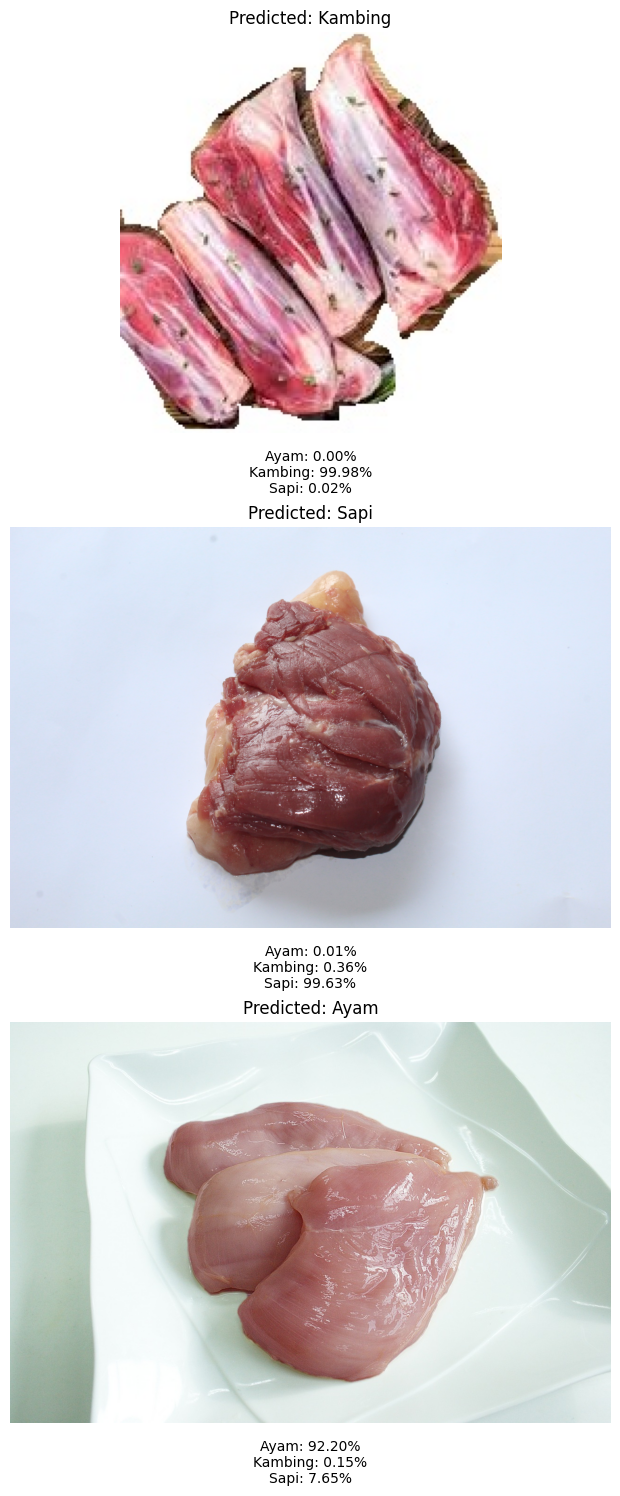

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
from io import BytesIO

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/daging_cnn_model.h5')
class_names = ['Ayam', 'Kambing', 'Sapi']

# Preprocess the image for prediction
def preprocess_image(image, target_size=(128, 128)):
    img = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict the image's class
def predict_image(image):
    img = preprocess_image(image)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]

    probabilities = predictions[0]
    class_probabilities = {class_names[i]: probabilities[i] for i in range(len(class_names))}

    return class_names[predicted_class], class_probabilities

# Display the uploaded image
def display_image(image, predicted_class, class_probabilities):
    img = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot the image and predictions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f'The predicted class for the image is: {predicted_class}')
    print("Class probabilities:")
    for class_name, probability in class_probabilities.items():
        print(f"{class_name}: {probability * 100:.2f}%")

# Upload the images using Google Colab's file upload
uploaded = files.upload()

# Initialize a list to store the results for saving later
prediction_results = []

# Process the uploaded images
for image_name in uploaded.keys():
    # Read the image content
    uploaded_image = uploaded[image_name]

    # Predict and display results
    predicted_class, class_probabilities = predict_image(uploaded_image)

    # Display the image and results
    display_image(uploaded_image, predicted_class, class_probabilities)

    # Store the image and results for saving to a file
    prediction_results.append((image_name, predicted_class, class_probabilities))

# Save Prediction Results Plot
fig, axes = plt.subplots(len(uploaded), 1, figsize=(10, 5 * len(uploaded)))

# If there is only one image, axes is not a list but a single object
if len(uploaded) == 1:
    axes = [axes]

# Loop over images and display results on the plot
for i, (image_name, predicted_class, class_probabilities) in enumerate(prediction_results):
    img = cv2.imdecode(np.frombuffer(uploaded[image_name], np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {predicted_class}")

    # Add probabilities to the plot
    prob_text = "\n".join([f"{class_name}: {probability * 100:.2f}%" for class_name, probability in class_probabilities.items()])
    axes[i].text(0.5, -0.1, prob_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

# Adjust layout and save the plot
plt.tight_layout()
save_path = '/content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/prediction_percobaan_C.png'
plt.savefig(save_path)
print(f"Prediction results plot saved as {save_path}")

# Show plot
plt.show()


Saving object3.jpg to object3.jpg


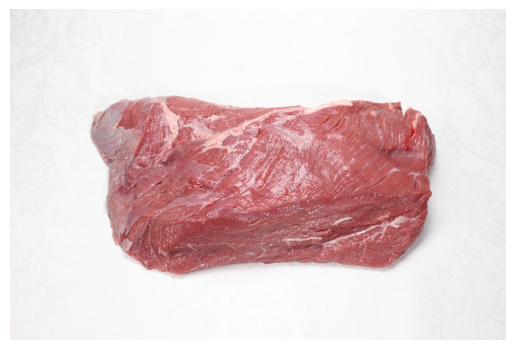

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
The predicted class for the image is: Sapi
Class probabilities:
Ayam: 0.00%
Kambing: 21.47%
Sapi: 78.53%


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
from io import BytesIO

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/dataset/Minggu12/Dataset_Daging_Hewan_Ternak/daging_cnn_model.h5')
class_names = ['Ayam', 'Kambing', 'Sapi']

# Preprocess the image for prediction
def preprocess_image(image, target_size=(128, 128)):
    img = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict the image's class
def predict_image(image):
    img = preprocess_image(image)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]

    probabilities = predictions[0]
    class_probabilities = {class_names[i]: probabilities[i] for i in range(len(class_names))}

    return class_names[predicted_class], class_probabilities

# Display the uploaded image
def display_image(image):
    img = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Upload the image using Google Colab's file upload
uploaded = files.upload()

# Process the uploaded image
for image_name in uploaded.keys():
    # Read the image content
    uploaded_image = uploaded[image_name]

    # Display the image
    display_image(uploaded_image)

    # Predict and display results
    predicted_class, class_probabilities = predict_image(uploaded_image)

    print(f'The predicted class for the image is: {predicted_class}')
    print("Class probabilities:")
    for class_name, probability in class_probabilities.items():
        print(f"{class_name}: {probability * 100:.2f}%")